# Project Overview: 


## Collaborators:

1. Agnes Chomba

2. Derrick Malinga

3. Erick Okacha

4. Judah Odida

5. Lucas Ominde

6. Nick  Mwai

7. Olgah Omollo

# FinComBot - Compliance Chatbot 

## 1. Background
Financial institutions face increasing pressure to comply with stringent regulatory frameworks governing customer onboarding, Know Your Customer (KYC), Customer Due Diligence (CDD), Enhanced Due Diligence (EDD), Anti-Money Laundering (AML), Counter Terrorism Financing, Counter Proliferation Financing (CPF), and sanctions screening. These obligations are complex, continuously evolving, and vary across jurisdictions.

Staff often face difficulties accessing and interpreting regulatory documents and internal policies, leading to:
-	Delays in onboarding, affecting customer experience and revenue.
-	Inconsistent application of compliance procedures.
-	Overdependence on compliance officers for basic guidance.
-	Increased risk of regulatory breaches which may lead to fining by regulators and put the bank at risk of its license being suspended.





#  2. Business Objective

a.)  Build a chatbot that retrieves accurate compliance information 
from the bank’s KYC/AML/CTF/CPF policies and responds to staff queries.



## 3. Target Audience

a.) Front office / Relationship Managers (who onboard customers)

b.)  Operations staff (who process documents)

c.) Compliance officers (for guidance validation)

d.) New staff (as a training tool)

e.) Risk & Audit teams (for oversight)


##  4. Data Understanding
Data Source: 
a. Internal compliance policy, stored in Word (.docx) format,  Contains: KYC procedures, AML red flags, CDD/EDD checklists, risk rating methodology, regulatory guidelines (FATF, CBK, CMA)

Data Characteristics:Unstructured text (paragraphs, checklists), Multiple sections (policies, procedures, workflows), Needs preprocessing before AI ingestion


### 1. Data Preprocessing

In [1]:
import pandas as pd
import docx as docx
from docx.shared import Pt

In [2]:
import os

# Ensure TensorFlow is disabled (avoids keras issues)
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF"] = "1"

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import docx


Load the raw document (.docx) 

In [3]:
from docx import Document

def load_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs if para.text.strip()])

# Use the correct relative path
text = load_docx(r"Data\SEC5 - OPENING OF ACCOUNTS (004).docx.docx")
print(text[:500])  # preview first 500 characters


OPENING OF ACCOUNTS
TABLE OF CONTENTS
1	INTRODUCTION	11
1.1	General	11
2	ACCOUNT OPENING REQUIREMENTS	11
2.1	Know Your Customer (KYC)	11
2.2	Account Opening Requirements on Referee	11
2.3	Documentation Required for Account Opening	12
2.4	Account Opening Requirements for Foreign Nationals	34
2.4.1	Resident Foreign Nationals	34
2.4.2	Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).	35
2.4.3	Minimum requirements for Resident Foreigners	35
2.4.4	Acc


Clean & normalize text — Notebook cells

In [4]:
# === Cell A: Preview + basic stats ===
import os, textwrap

print("Working dir:", os.getcwd())
print("Text variable exists:", 'text' in globals())

orig = text  # your loaded document text
print("\n--- ORIGINAL STATS ---")
print("Characters:", len(orig))
print("Words:", len(orig.split()))
non_empty_lines = [L for L in orig.splitlines() if L.strip()]
print("Non-empty lines:", len(non_empty_lines))
print("\n--- PREVIEW (first 1000 chars) ---\n")
print(textwrap.fill(orig[:1000], width=120))


Working dir: c:\Users\User\OneDrive\Desktop\Group_5_Capstone_Project\Group_5_Capstone_Project
Text variable exists: True

--- ORIGINAL STATS ---
Characters: 165696
Words: 26098
Non-empty lines: 2529

--- PREVIEW (first 1000 chars) ---

OPENING OF ACCOUNTS TABLE OF CONTENTS 1       INTRODUCTION    11 1.1     General 11 2       ACCOUNT OPENING REQUIREMENTS
11 2.1     Know Your Customer (KYC)        11 2.2     Account Opening Requirements on Referee 11 2.3     Documentation
Required for Account Opening      12 2.4     Account Opening Requirements for Foreign Nationals      34 2.4.1   Resident
Foreign Nationals      34 2.4.2   Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential
Guidelines).     35 2.4.3   Minimum requirements for Resident Foreigners    35 2.4.4   Account Opening Requirements for
Companies with Foreign Nationals as Directors  35 2.4.5   Account Opening Requirements for Temporary Residents
(Students, Spouses, Attaché’s to Foreign Missions i

In [ ]:
# === Cell B: Cleaning function  ===
import re
import unicodedata

def clean_text(
    text,
    lowercase=False,
    remove_empty_lines=True,
    normalize_unicode=True,
    normalize_whitespace=True,
    remove_page_numbers=True
):
    """
    Clean and normalize a document string.

    - normalize_unicode: use NFKC normalization (fixes weird unicode forms)
    - remove_page_numbers: drop standalone numeric lines like "1" or "Page 1"
    - remove_empty_lines: remove empty/blank lines and collapse into paragraphs
    - normalize_whitespace: collapse repeated spaces/tabs/newlines
    - lowercase: optional - keep off by default (recommended: keep case for embeddings)
    """
    if normalize_unicode:
        text = unicodedata.normalize("NFKC", text)

    # Normalize line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # Replace non-breaking spaces
    text = text.replace("\u00A0", " ")

    # Normalize common smart quotes to ascii quotes
    text = text.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")

    # Remove unprintable control characters (keep \n and \t)
    text = "".join(ch for ch in text if ch.isprintable() or ch in "\n\t")

    # Optionally drop page headers/footers that look like "Page 1" or just "1"
    if remove_page_numbers:
        out_lines = []
        for line in text.split("\n"):
            s = line.strip()
            # common patterns to remove
            if re.fullmatch(r'page\s*\d+', s, flags=re.IGNORECASE):
                continue
            if re.fullmatch(r'\d{1,4}', s):  # standalone numbers (likely page numbers)
                continue
            out_lines.append(line)
        text = "\n".join(out_lines)

    # Trim each line, optionally remove empty lines and join paragraphs with a blank line
    if remove_empty_lines:
        lines = [line.strip() for line in text.split("\n")]
        lines = [line for line in lines if line != ""]  # drop blank lines
        # join paragraphs with a double newline (keeps paragraph boundaries)
        text = "\n\n".join(lines)

    # Normalize internal whitespace
    if normalize_whitespace:
        # collapse multiple spaces/tabs to single space
        text = re.sub(r'[ \t]+', ' ', text)
        # collapse 3+ newlines to two (we keep paragraph separation)
        text = re.sub(r'\n{3,}', '\n\n', text)
        text = text.strip()

    if lowercase:
        text = text.lower()

    return text


In [6]:
# === Cell C: Apply cleaning, show before/after, save cleaned file ===
cleaned = clean_text(text, lowercase=False)   # keep case by default

# quick before/after stats
print("ORIGINAL: chars =", len(text), "words =", len(text.split()))
print("CLEANED : chars =", len(cleaned), "words =", len(cleaned.split()))

# preview first 1000 chars of cleaned text
print("\n--- CLEANED PREVIEW ---\n")
print(cleaned[:1000])

# save cleaned text to Data/ (should be .gitignored)
out_path = r"Data/SEC5 - OPENING OF ACCOUNTS (004)_cleaned.txt"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(cleaned)

print("\nSaved cleaned text to:", out_path)


ORIGINAL: chars = 165696 words = 26098
CLEANED : chars = 167563 words = 26098

--- CLEANED PREVIEW ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines). 35

2.4.3 Minimum requirements for Resident Foreigners 35

2.4.4 Account Opening Requirements for Companies with Foreign Nationals as Directors 35

2.4.5 Account Opening Requirements for Temporary Residents (Students, Spouses, Attaché's to Foreign Missions in Kenya, Next Of Kin etc.) 36

2.4.6 Non-resident Foreigners 36

2.5 Account Opening Requirements for Scrap Metal Dealers 36

2.5.1 Additional Account opening requirements for Scrap Metal Dealer

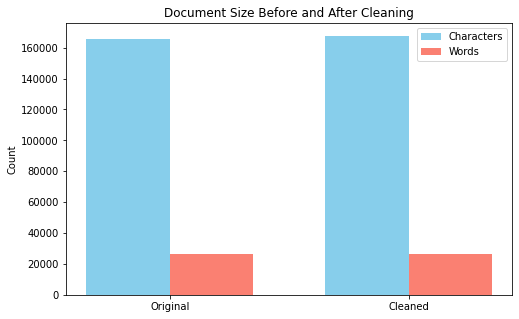

In [7]:
# === Cell D: Visualize before/after cleaning ===
import matplotlib.pyplot as plt

# Compute stats
stats = {
    "Original": {"chars": len(text), "words": len(text.split())},
    "Cleaned": {"chars": len(cleaned), "words": len(cleaned.split())}
}

labels = list(stats.keys())
chars = [stats[label]["chars"] for label in labels]
words = [stats[label]["words"] for label in labels]

# Plot
fig, ax = plt.subplots(figsize=(8,5))

bar_width = 0.35
x = range(len(labels))

# Two bars for chars and words
ax.bar(x, chars, width=bar_width, label='Characters', color='skyblue')
ax.bar([i + bar_width for i in x], words, width=bar_width, label='Words', color='salmon')

ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Document Size Before and After Cleaning')
ax.legend()

plt.show()


The cleaning step successfully reduces minor noise without compromising meaningful content, making the document suitable for further processing.

In [8]:
# === Cell E: Split text into chunks ===
import re

def split_text_into_chunks(text, max_chars=500, overlap=50):
    """
    Splits text into chunks of max_chars with optional overlap.
    Keeps sentences intact (splits on punctuation).
    """
    # Split text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_chars:
            current_chunk += " " + sentence if current_chunk else sentence
        else:
            chunks.append(current_chunk.strip())
            # start new chunk with overlap
            current_chunk = " ".join(current_chunk.split()[-overlap:]) + " " + sentence if overlap else sentence

    # Add last chunk
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

# Apply chunking
chunks = split_text_into_chunks(cleaned, max_chars=500, overlap=50)

print("Number of chunks:", len(chunks))
print("\n--- Sample chunk ---\n")
print(chunks[0])


Number of chunks: 320

--- Sample chunk ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).


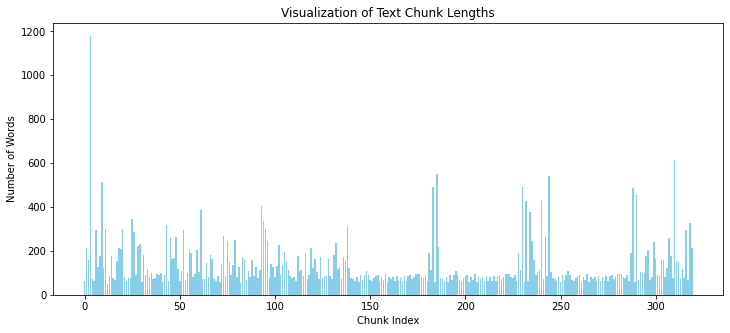

In [9]:
import matplotlib.pyplot as plt

# Assume `chunks` is your list of text chunks
chunk_lengths = [len(chunk.split()) for chunk in chunks]

plt.figure(figsize=(12, 5))
plt.bar(range(len(chunk_lengths)), chunk_lengths, color='skyblue')
plt.xlabel("Chunk Index")
plt.ylabel("Number of Words")
plt.title("Visualization of Text Chunk Lengths")
plt.show()


A histogram to show if there are outliers in the Chunks

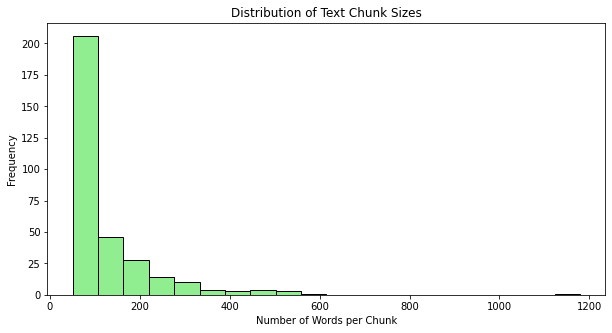

In [10]:
import matplotlib.pyplot as plt

# Compute number of words in each chunk
chunk_lengths = [len(chunk.split()) for chunk in chunks]

# Create a histogram
plt.figure(figsize=(10,5))
plt.hist(chunk_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Words per Chunk")
plt.ylabel("Frequency")
plt.title("Distribution of Text Chunk Sizes")
plt.show()


- Chunk Length Analysis:
The histogram shows the distribution of text chunk lengths after splitting the document. Most chunks are below 50 words, reflecting short paragraphs, bullet points, or sentence fragments. One chunk reaches 200 words, which likely corresponds to a long uninterrupted section in the document (e.g., a detailed paragraph or table).Chunk Length Analysis:
The histogram shows the distribution of text chunk lengths after splitting the document. Most chunks are below 50 words, reflecting short paragraphs, bullet points, or sentence fragments. One chunk reaches 200 words, which likely corresponds to a long uninterrupted section in the document (e.g., a detailed paragraph or table).